In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter

import helpers

import pandas as pd
# import numpy as np
from PIL import Image
import PIL
import matplotlib as mpl

from skimage import exposure
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.signal import argrelextrema


In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'

img = cv2.imread(filename,0)

# fix brightness and shadowing issues
# https://stackoverflow.com/questions/44047819/increase-image-brightness-without-overflow/44054699#44054699

norm_img = helpers.fix_brightness(img)

In [3]:
# apply histogram equalization for vesicle picking
# https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py
imarr_hist = exposure.equalize_hist(norm_img)


In [4]:
# remove data from outside of core

# imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)
imarr_hist = helpers.remove_data_based_on_radius(imarr_hist, mask_value=np.nan)

In [5]:
# try different gaussian blurring based on sigma values

gauss_sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# blurs = [gaussian_filter(imarr_maskradius, sigma=sigma) for sigma in gauss_sigmas]
blurs = [gaussian_filter(imarr_hist, sigma=sigma) for sigma in gauss_sigmas]

In [6]:
# calculate peaks

peaks_etc = [helpers.get_peaks_means_stds(b, height=1e3, width=4) for b in blurs]

# label peaks
peak_labled = [helpers.label_by_peaks(blurs[s-1], peaks_etc[s-1]) for s in gauss_sigmas]

0.78
[0. 2.]


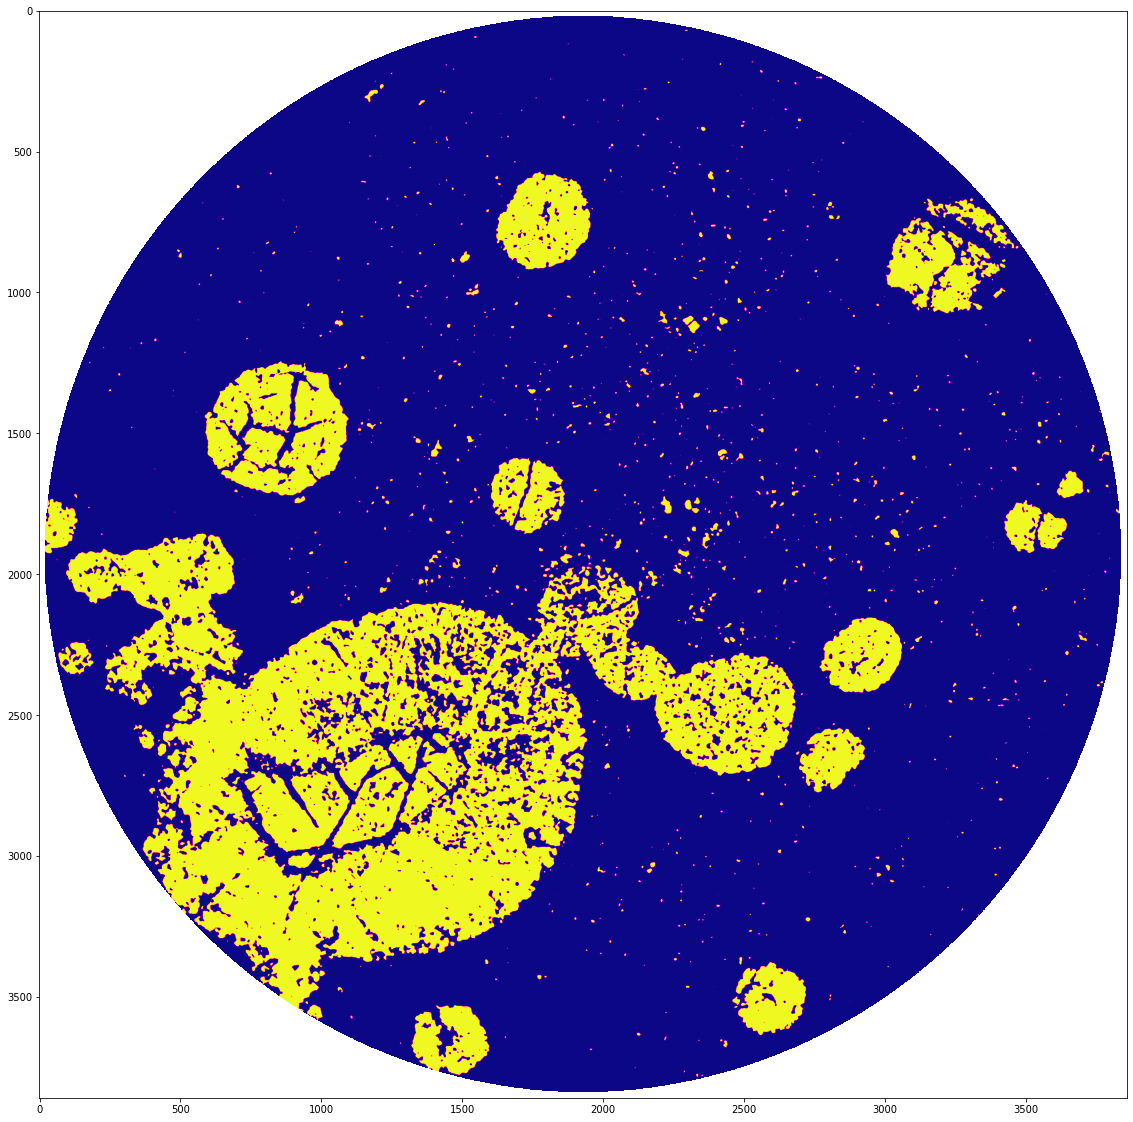

In [14]:
index = 0

n = len(peaks_etc[index]['peaks'])
bounds = np.arange(0, n+1, 1)

cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))

# bins = p.flatten()
# bincnt = pd.value_counts(bins).sort_index()

step = (bounds[-1]/bounds.shape[0])/2
ticks = [(b*bounds.max()/bounds.shape[0])+step for b in bounds]


fig, ax = plt.subplots(figsize=(20, 20))

z = np.copy(peak_labled[index])
z[z == 1] = 0
# z[z == 2] = 3
# z[z == 3] = 0

z = gaussian_filter(z, sigma=4)

# z[z>=0.5] = 2
# z[z<1] = 0

# find local minima in histogram to separate vesicles from noise
h, e = np.histogram(z.flatten(), bins=np.linspace(0, 2, 201))
splitter = e[argrelextrema(h, np.less, order=10)][0]
print(splitter)

z[z >= splitter] = 2
z[z < splitter] = 0

ax.imshow(z, cmap='plasma')
# cbar = ax.imshow(z, cmap=cmap, vmin=0, vmax=bounds.max())
print(np.unique(z[~np.isnan(z)]))

# cbar = fig.colorbar(cbar, ax=ax, shrink=0.75, ticks=ticks)
# cbar.ax.set_yticklabels(bounds)

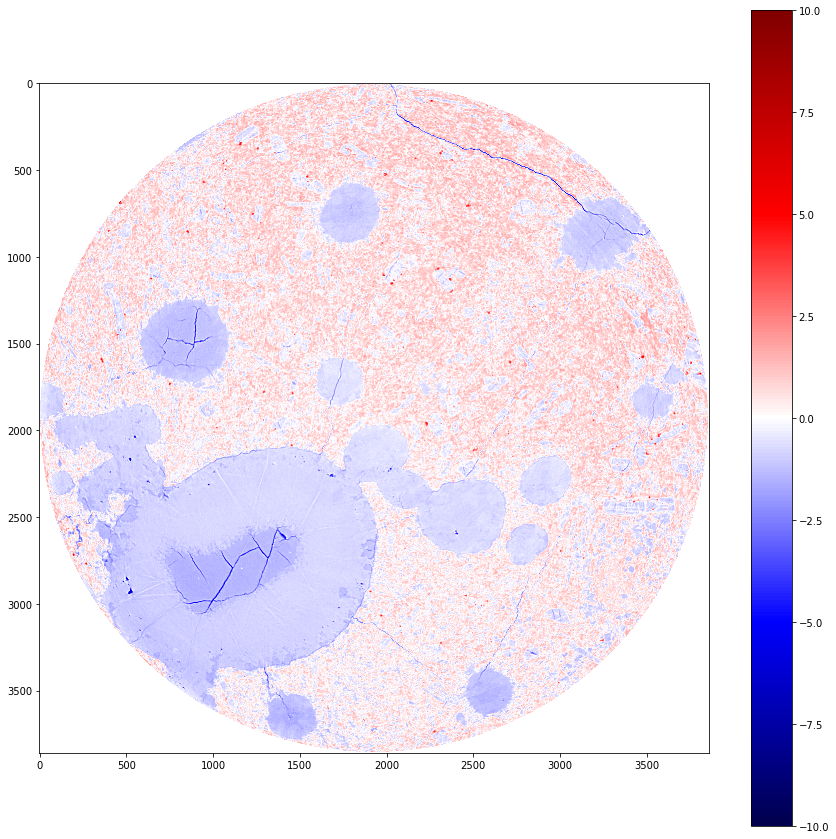

In [9]:
# calculate global mean and rescale values

zim = helpers.zscore(helpers.remove_data_based_on_radius(img, np.nan))

fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(zim, cmap='seismic', vmin=-10, vmax=10)
fig.colorbar(cbar)

In [10]:
# filter out all data that is not fracture

zim_remove = zim.copy()
zim_remove[zim_remove > -1.75] = 0

x1, y1 = zim_remove.nonzero()

zeros = np.zeros_like(zim_remove)

zeros[x1, y1] = 1

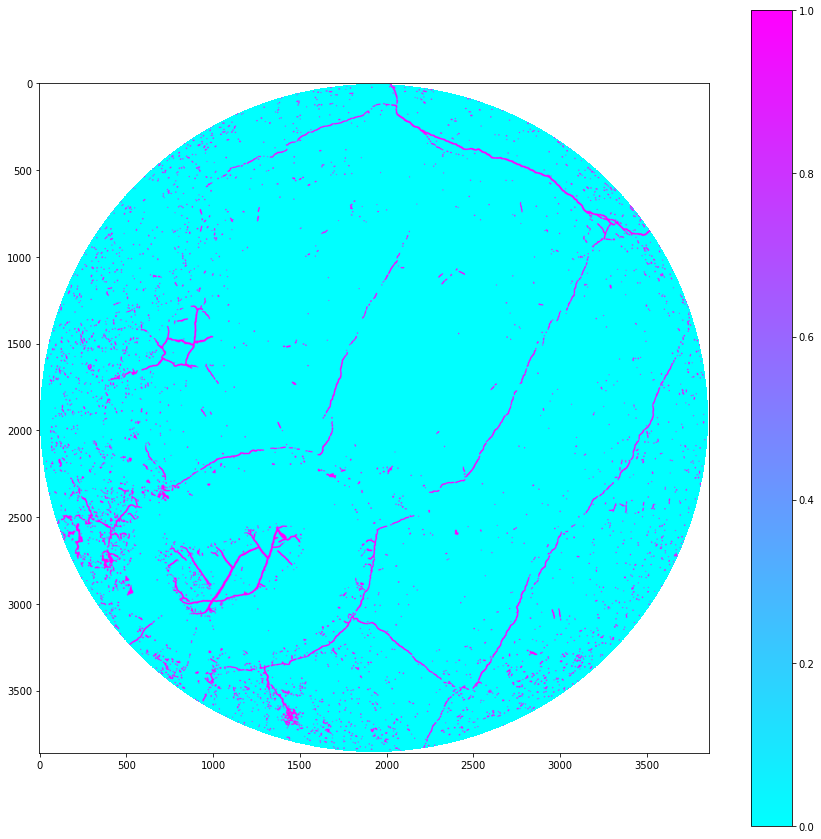

In [11]:
# replace all data as either 1 or 0 for fracture identification

# footprint condition says value should be greater
# in all directions
footprint1 = np.array(
    [[1, 1, 1]
    ,[1, 0, 1]
    ,[1, 1, 1]]
)

footprint2 = np.array(
    [[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 0, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]]
)

# creates a window based on the given footprint
# to compare neighbors and replace values on 
# nearest maximum value
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
newim = ndimage.median_filter(zeros, footprint=footprint1, mode='constant')
newim = ndimage.maximum_filter(newim, footprint=footprint2, mode='constant')
# newim = ndimage.maximum_filter(zim_remove, footprint=footprint2, mode='constant')

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

cbar = ax.imshow(imlabeled, cmap='cool')

fig.colorbar(cbar)


In [13]:
frac = imlabeled.flatten()
frac[~np.isnan(frac)]

array([0., 1., 1., ..., 1., 1., 0.])

In [15]:
zeros = np.zeros_like(imlabeled)

In [20]:
ves_x, ves_y = z.nonzero()
zeros[ves_x, ves_y] = 1

frac_x, frac_y = imlabeled.nonzero()
zeros[frac_x, frac_y] = 2

zeros = helpers.remove_data_based_on_radius(zeros, np.nan)

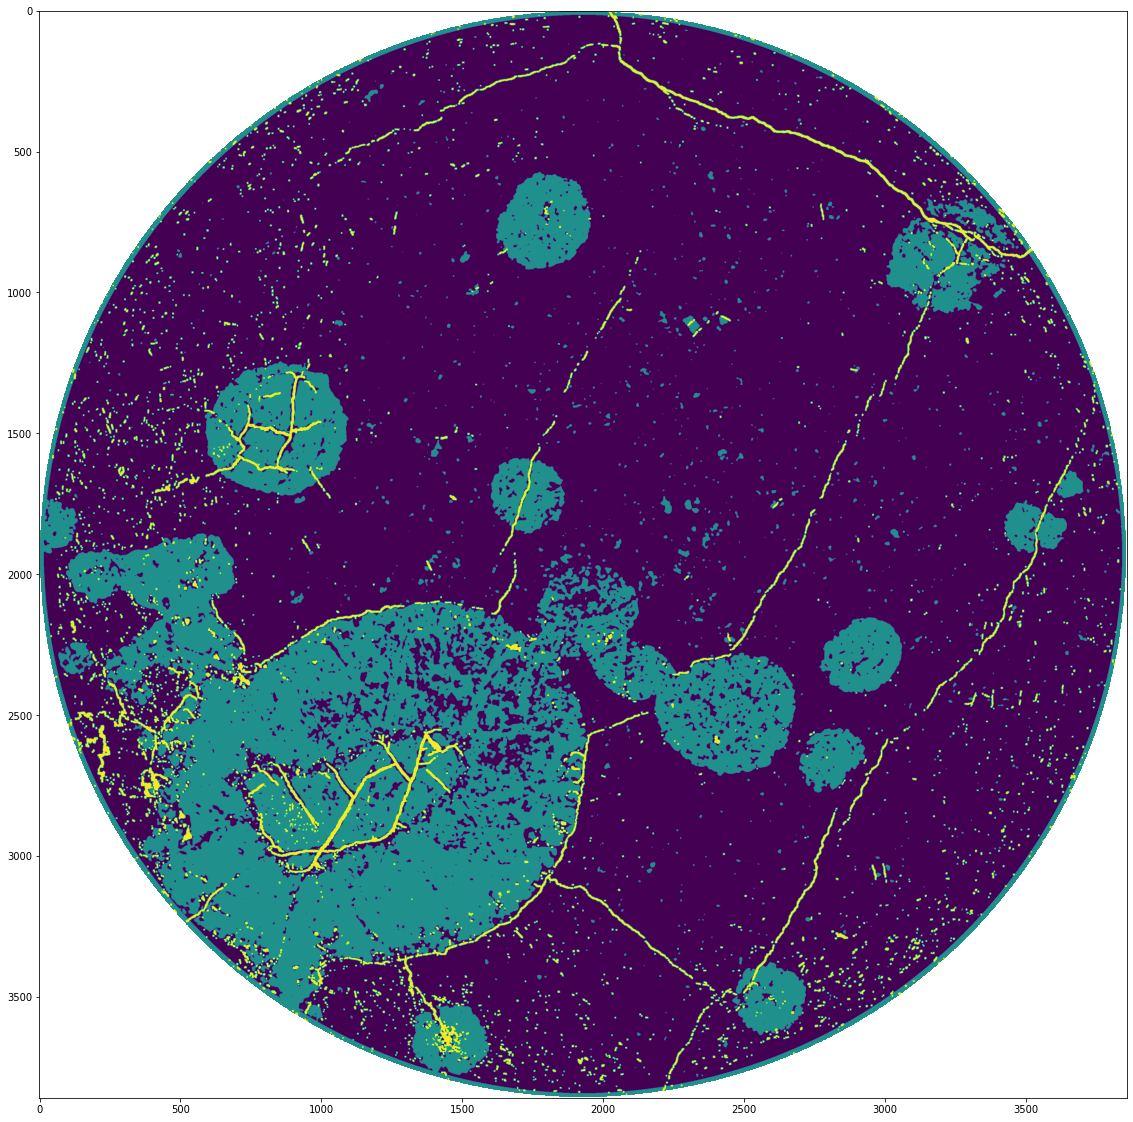

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(zeros)